In [5]:
import numpy as np
from time import time
import os
import sys
import scipy
import math
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import pandas as pd
import psutil
from tqdm import tqdm
sys.path.insert(0, '/hominterp1de/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
#import ants
import bigbadbrain as bbb
from scipy.linalg import toeplitz
import scipy.linalg as sl
from scipy.signal import convolve2d
#from scipy.signal imposcipyrt convolve
import sklearn
from sklearn.linear_model import LassoLarsIC
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn import linear_model

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import cv2

import statsmodels.api as sm

%matplotlib inline

In [10]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_47/func_0'

In [11]:
brain_path = os.path.join(directory, 'imaging', 'functional_channel_2.nii')
brain = bbb.load_numpy_brain(brain_path)
dims = bbb.get_dims(brain)
print('brain shape is x,y,z,t {}'.format(brain.shape))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 10.62 sec
brain shape is x,y,z,t (129, 86, 45, 4817)


In [12]:
save_path = os.path.join(directory, 'imaging')

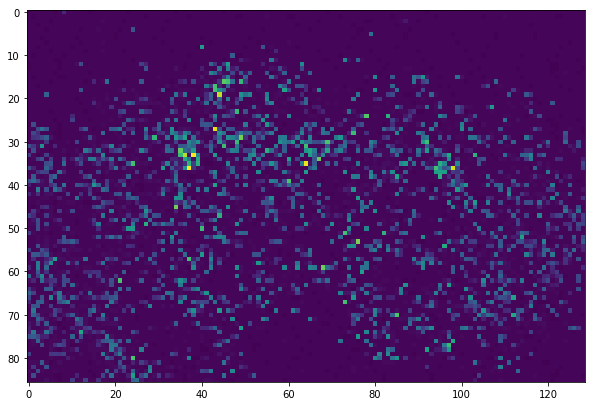

In [13]:
fig = plt.figure(figsize=(10,10))
plt.imshow(brain[:,:,20,0].T)

### Output Bleaching Curve

In [ ]:
plt.rcParams.update({'font.size': 24})

percent_signal_lost: 52.6708157504699


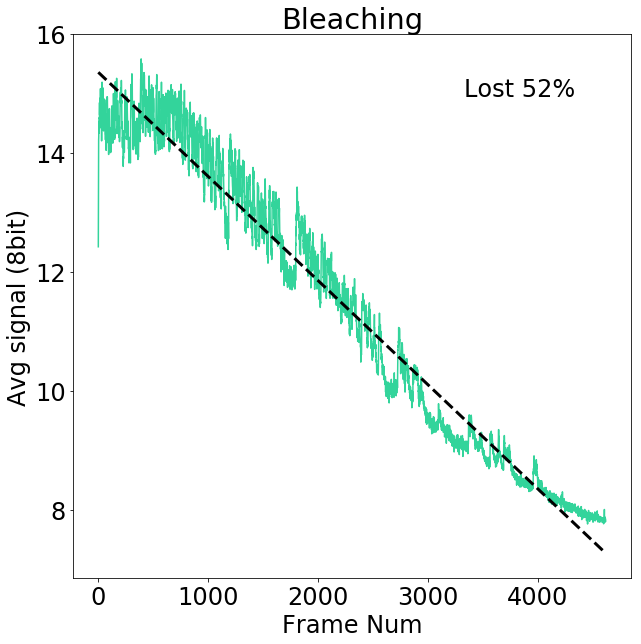

In [122]:
fig = plt.figure(figsize=(10,10))
data_mean = np.mean(brain,axis=(0,1,2))
xs = np.arange(brain.shape[-1])
plt.plot(data_mean,color=np.divide((51, 212, 155),255))
linear_fit = np.polyfit(xs, data_mean, 1)
plt.plot(np.poly1d(linear_fit)(xs),color='k',linewidth=3,linestyle='--')
plt.text

plt.xlabel('Frame Num')
plt.ylabel('Avg signal (8bit)')
plt.title('Bleaching')

percent_signal_lost = linear_fit[0]*brain.shape[-1]/linear_fit[1]*-100
print('percent_signal_lost: {}'.format(percent_signal_lost))
plt.text(0.8,0.9,
         'Lost {}%'.format(int(percent_signal_lost)),
         horizontalalignment='center',
         verticalalignment='center',
         transform=plt.gca().transAxes)

fname = os.path.join(save_path, 'bleaching_0.png')
plt.savefig(fname,dpi=100,bbox_inches='tight')

### Output bleaching histogram

In [123]:
threshold = threshold_triangle(np.ndarray.flatten(brain[:,:,:,::100]))

Text(0.5, 1.0, 'Bleaching Histogram')

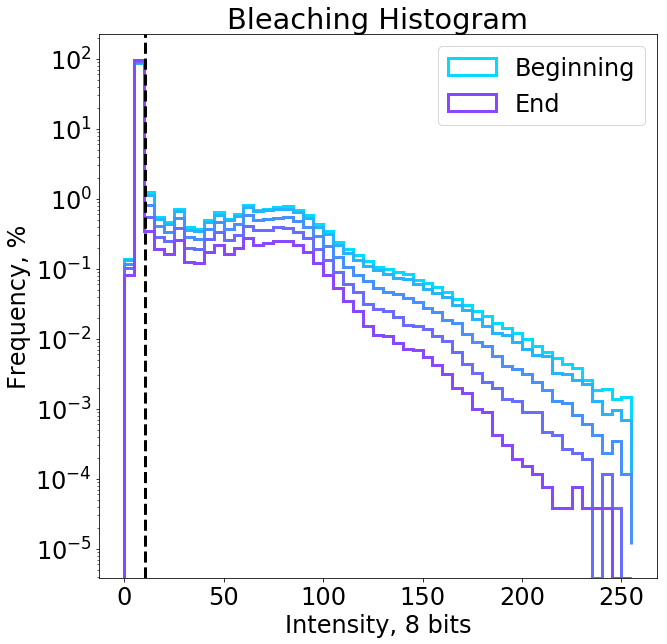

In [133]:
bins = np.ndarray.tolist(np.arange(0,260,5))
fig = plt.figure(figsize=(10,10))
num_steps = 5
frame_jump_size = 200
step = int(brain.shape[-1]/num_steps)

start_color = (4,217,255)
end_color = (170,35,255)
color_increment = np.subtract(end_color, start_color)/num_steps
bin_save = []

for i in range(num_steps):
    start = step*i
    end = start+step
    vector = np.ndarray.flatten(brain[:,:,:,start:end:frame_jump_size])
    weights = np.ones_like(vector)/float(len(vector))
    if i == 0:
        label = 'Beginning'
    elif i == num_steps-1:
        label = 'End'
    else:
        label = None
    color = tuple(start_color + color_increment * i)
    color = np.divide(color,255)
    binned,throwaway,throwaway2=plt.hist(vector,
                                         bins,
                                         weights=weights*100,
                                         log=True,
                                         label=label,
                                         stacked=True,
                                         histtype='step',
                                         linewidth=3,
                                         color=color)
    bin_save.append(binned)
plt.axvline(threshold,color='k',linewidth=3,linestyle='--')
plt.xlabel("Intensity, 8 bits")
plt.ylabel("Frequency, %")
plt.legend(loc=1)
plt.title("Bleaching Histogram")

fname = os.path.join(save_path, 'bleaching_1.png')
plt.savefig(fname,dpi=100,bbox_inches='tight')

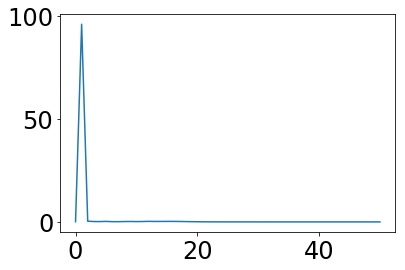

In [132]:
plt.plot(binned)

### How many pixels are below signal threshold?

In [125]:
step = 10
percent_above_thresh = []
for i in range(0,brain.shape[-1],step):
    data = brain[:,:,:,i]
    percent_above_thresh.append(len(data[data>threshold])/len(np.ndarray.flatten(data)))

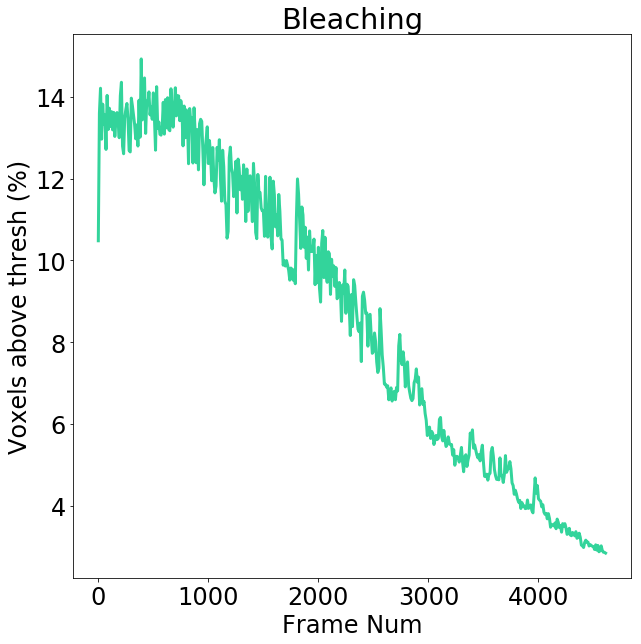

In [126]:
fig = plt.figure(figsize=(10,10))
xs = np.arange(0,brain.shape[-1],step)
plt.plot(xs, np.multiply(percent_above_thresh,100),color=np.divide((51, 212, 155),255),linewidth=3)
plt.ylabel('Voxels above thresh (%)')
plt.xlabel('Frame Num')
plt.title('Bleaching')

fname = os.path.join(save_path, 'bleaching_2.png')
plt.savefig(fname,dpi=100,bbox_inches='tight')

### Save data

In [137]:
output_data = {'percent_signal_lost': percent_signal_lost,
               'bleaching_slope': linear_fit[0],
               'threshold': threshold,
               'percent_above_thresh': percent_above_thresh,
               'intensity_histogram_over_time': bin_save}

In [138]:
save_file = os.path.join(save_path, 'bleaching_analysis.npy')
np.save(save_file, output_data)

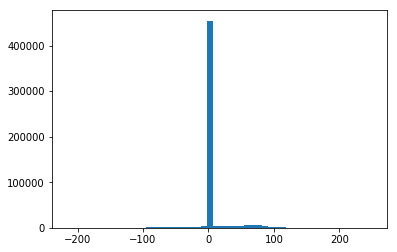

In [36]:
plt.hist(np.ndarray.flatten(brain[:,:,:,0])-np.ndarray.flatten(brain[:,:,:,-1]),bins=50);

In [12]:
np.max(brain)

255.0

(0, 20)

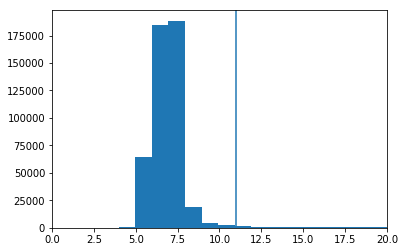

In [105]:
thing1,thing2,thing3=plt.hist(np.ndarray.flatten(brain[:,:,:,0]),bins=255)
plt.axvline(11)
plt.xlim(0,20)

In [103]:
threshold_triangle(np.ndarray.flatten(brain[:,:,:,0]))

11.3671875

In [111]:
len(brain[:,:,:,0][brain[:,:,:,0]<11.3671875])/len(np.ndarray.flatten(brain[:,:,:,0]))

0.8975906635802469

In [112]:
#What % of voxels are background?
i = 0
threshold = threshold_triangle(np.ndarray.flatten(brain[:,:,:,0]))
data = brain[:,:,:,0]
background = len(data[data<threshold])/len(np.ndarray.flatten(data))

In [83]:
data = brain[:,:,:,0]
len(data[data<threshold])/len(np.ndarray.flatten(data))

0.8975906635802469

In [29]:
threshold = threshold_triangle(np.ndarray.flatten(brain[:,:,:,::100]))

In [30]:
threshold

10.400390625

In [113]:
background

0.8975906635802469

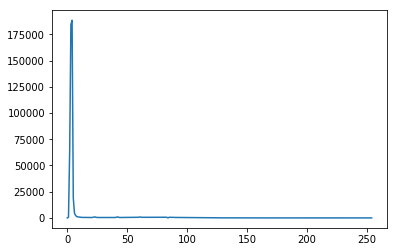

In [99]:
plt.plot(thing1)

ValueError: x and y can be no greater than 2-D, but have shapes (128,) and (128, 90, 45)

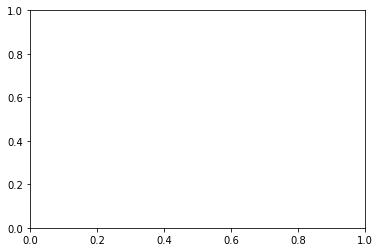

In [15]:
plt.plot(np.mean(brain,axis=-1))

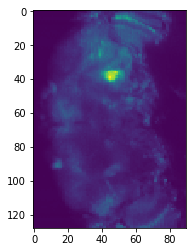

In [17]:
plt.imshow(np.mean(brain,axis=-1)[:,:,20])

In [13]:
np.arange(brain.shape[-1])

array([   0,    1,    2, ..., 4617, 4618, 4619])

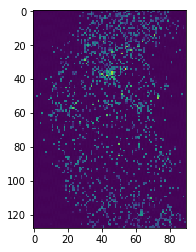

In [22]:
plt.imshow(brain[:,:,20,0])

In [23]:
np.count_nonzero(brain[:,:,20,0])

11520

In [25]:
np.size(brain[:,:,20,0])

11520

In [26]:
brain[:,30,20,0]

array([  6.,   6.,   7.,   7.,   7.,   7.,   6.,   6.,   6.,   7.,   7.,
         7.,  12., 117.,   6.,   6.,   7.,  90.,  55.,  30.,  84.,  76.,
        84.,  59.,  91.,   5.,   6.,  19., 112., 169.,   7.,   7.,   6.,
         6.,   5.,   5.,   6.,   8.,  90.,   7.,   8.,   6.,   7.,   6.,
       103.,  29.,  63.,   6.,   7.,   6.,  78.,   7.,   8.,   7.,   6.,
         6.,   5.,   5.,   6.,   6.,   6.,   7.,   7.,   7.,   7.,   7.,
         6.,   6.,   5.,   6.,   5.,   7.,   7.,   7.,  10.,  80.,   7.,
         6.,   6.,   5.,   5.,   6.,   6.,   8.,   7.,   7.,   7.,   8.,
        86.,   6.,   6.,   5.,   6.,   7.,   6.,  19.,  74.,   7.,   7.,
         6.,   6.,   5.,   5.,   6.,   7.,   7.,  38.,   7.,   7.,   8.,
         6.,   5.,   6.,   6.,  67.,   8.,   7.,   6.,   6.,   5.,   5.,
         6.,   7.,   7.,   7.,   6.,   6.,   5.])

(array([1.3240e+04, 1.1022e+04, 1.6161e+04, 9.4030e+03, 2.4660e+03,
        1.2200e+03, 5.6300e+02, 1.9000e+02, 5.3000e+01, 1.1000e+01]),
 array([ 11. ,  35.4,  59.8,  84.2, 108.6, 133. , 157.4, 181.8, 206.2,
        230.6, 255. ]),
 <a list of 10 Patch objects>)

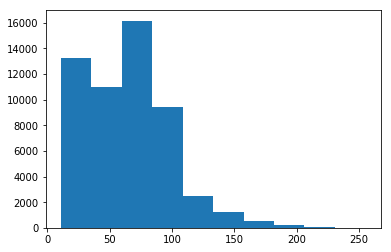

In [29]:
plt.hist(brain[:,:,:,0][brain[:,:,:,0]>10])

(array([4.74828e+05, 1.04920e+04, 1.52270e+04, 1.23110e+04, 3.24300e+03,
        1.39200e+03, 6.27000e+02, 2.07000e+02, 6.20000e+01, 1.10000e+01]),
 array([  3. ,  28.2,  53.4,  78.6, 103.8, 129. , 154.2, 179.4, 204.6,
        229.8, 255. ]),
 <a list of 10 Patch objects>)

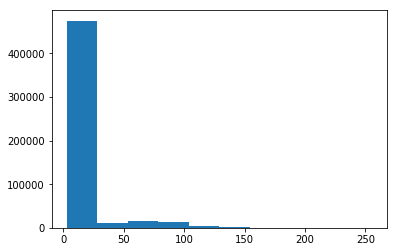

In [50]:
plt.hist(np.ndarray.flatten(brain[:,:,:,0]))

In [32]:
np.mean(brain[:,:,:,100][brain[:,:,:,100]>10])

66.95578293440526

In [31]:
np.mean(brain[:,:,:,-1][brain[:,:,:,-1]>10])

58.8300059693573

In [33]:
np.mean(brain[:,:,:,100])

14.708263888888888

In [34]:
np.mean(brain[:,:,:,-1])

7.836481481481481